# Predicting the politics of native ad content

We left off a while ago with a dataset of native ad content scraped from across the web on various media website see [part I here](http://subtxt.in/web/2017/06/17/suggested_content) and [part II here](http://subtxt.in/web/2017/08/15/suggested_content_2). 

Picking up from this work, we want to see what a trained nueral network does with political classifications of these images. Luckily we made a naive pass at classifying the websites from which these images came, so we already have some labels to apply to the training data. Though now we'll see if any of it is meaningful.

To recap, based on the website the native content was hosted at, we assinged a political pre-disposition to that site (**left**, **right**, **center**, or **tabloid** -- for those websites that seemed to lean towards outrageous claims over political bias).

First, lets just do a once over of our data.

## Load the native ad content metadata

In [2]:
import pandas as pd

In [3]:
native_ad_df = pd.read_csv('../data/out/2017-08-30-01_47_native_ad_data_deduped.csv')

In [4]:
native_ad_df.head()

,_id,headline,link,img,provider,source,img_file,date,final_link,orig_article,img_host,link_host,source_class
0,ObjectId(58d90ce706e10d04f7e1b3d8),20 Cool Moments From Joe Biden’s Time In Office,http://scribol.com/a/news-and-politics/ways-jo...,https://console.brax-cdn.com/creatives/98c6400...,taboola,http://tmz.com,876aa5e83f6fb81a81908db3c02fdcc00d444000.png,2017-03-27T12:59:09.279Z,http://scribol.com/a/news-and-politics/ways-jo...,NaN,console.brax-cdn.com,scribol.com,tabloid
1,ObjectId(58d90ce706e10d04f7e1b3e0),25 Pics Donald Trump Doesn't Want You To See,http://adrzr.com/54f7?utm_source=8b4&utm_campa...,http://cdn.taboolasyndication.com/libtrc/stati...,taboola,http://tmz.com,d3a3f2f50c84529c08bb8314ae3aa66280f0cbc7.png,2017-03-27T12:59:13.038Z,http://detonate.com/pictures-that-trump-would-...,NaN,cdn.taboolasyndication.com,detonate.com,tabloid
2,ObjectId(58d90ce706e10d04f7e1b3e2),Do This Tonight to Make Fungus Disappear by Mo...,http://japanesetoenailfunguscode.com/?aff_id=4...,https://revcontent-p0.s3.amazonaws.com/content...,revcontent,http://worldstarhiphop.com/videos/,e2bb63d58e09bae569a90f64de24c93a2d008e34.jpg,2017-03-27T12:59:15.114Z,http://japanesetoenailfunguscode.com/?aff_id=4...,NaN,revcontent-p0.s3.amazonaws.com,japanesetoenailfunguscode.com,tabloid
3,ObjectId(58d90ce706e10d04f7e1b3e3),Here's What New Dental Implants Should Cost Yo...,http://gaindentalfixdeals.com/?affid=1016&s1=1...,https://revcontent-p0.s3.amazonaws.com/content...,revcontent,http://worldstarhiphop.com/videos/,f70f91d2ebf37e35480fe4f689477406adf9243e.jpg,2017-03-27T12:59:15.237Z,http://gaindentalfixdeals.com/?affid=1016&s1=1...,NaN,revcontent-p0.s3.amazonaws.com,gaindentalfixdeals.com,tabloid
4,ObjectId(58d90ce706e10d04f7e1b3e4),Michael Jordan Has Pretty Much Given Up on His...,http://trends.revcontent.com/click.php?d=vJdwp...,https://revcontent-p0.s3.amazonaws.com/content...,revcontent,http://worldstarhiphop.com/videos/,ab914b86682795c6d6624707b22b06f88f0e551a.jpg,2017-03-27T12:59:15.614Z,http://trends.revcontent.com/click.php?d=vJdwp...,NaN,revcontent-p0.s3.amazonaws.com,trends.revcontent.com,tabloid


In [5]:
native_ad_df.describe()

,_id,headline,link,img,provider,source,img_file,date,final_link,orig_article,img_host,link_host,source_class
count,43630,43630,43630,43630,43630,43630,43558,43630,43630,25177,43630,43630,43630
unique,43630,15219,35541,19311,4,24,19313,43629,30873,5195,568,2196,4
top,ObjectId(5900e9449e1e2a5cd5feb6bc),Nicole Kidman's Yacht Is Far From You'd Expect,http://topictracker.online/?utm_campaign=us-tb...,http://cdn.taboolasyndication.com/libtrc/stati...,taboola,http://tmz.com,f18167ca58fee4ae691a28ecd39b0c1afe2689e4.jpg,2017-05-30T04:49:40.273Z,http://www.zergnet.com/news/694817/kim-kardash...,http://elitedaily.com/women/elite-daily-wants-...,images.outbrain.com,www.zergnet.com,tabloid
freq,1,376,110,368,13431,5070,368,2,126,51,12259,7257,16005


## Slim down the metadata

Let's work with a smaller set of columns, we don't need everything.

For starting, we'll fetch the headline, provider, source, img_file, source_class.

In [8]:
slim_df = native_ad_df[['headline', 'provider', 'source', 'img_file', 'source_class']]

In [9]:
slim_df.head()

,headline,provider,source,img_file,source_class
0,20 Cool Moments From Joe Biden’s Time In Office,taboola,http://tmz.com,876aa5e83f6fb81a81908db3c02fdcc00d444000.png,tabloid
1,25 Pics Donald Trump Doesn't Want You To See,taboola,http://tmz.com,d3a3f2f50c84529c08bb8314ae3aa66280f0cbc7.png,tabloid
2,Do This Tonight to Make Fungus Disappear by Mo...,revcontent,http://worldstarhiphop.com/videos/,e2bb63d58e09bae569a90f64de24c93a2d008e34.jpg,tabloid
3,Here's What New Dental Implants Should Cost Yo...,revcontent,http://worldstarhiphop.com/videos/,f70f91d2ebf37e35480fe4f689477406adf9243e.jpg,tabloid
4,Michael Jordan Has Pretty Much Given Up on His...,revcontent,http://worldstarhiphop.com/videos/,ab914b86682795c6d6624707b22b06f88f0e551a.jpg,tabloid


In [10]:
slim_df.source_class.value_counts()

tabloid    16005
left       12063
right       9254
center      6308
Name: source_class, dtype: int64

## Simplify the dataset (for now)

We want to try things out first with a simple binary classification problem. And we also don't have very many images to work with. Let's only look at left v. right web source classifications. 

For this we'll use the Keras dog/cat approach found here: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [12]:
slim_df_binary = slim_df.loc[slim_df['source_class'].isin(['left', 'right'])]

In [14]:
assert len(slim_df_binary) == (12063 + 9254)

And drop any image duplicates, not trying for a multilabel classifier yet in the event that the same image came from different source classifications

In [15]:
slim_df_binary.drop_duplicates(subset ="img_file", keep = False, inplace = True) 

/Users/dogrdon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [16]:
len(slim_df_binary)

9659

In [17]:
slim_df_binary.source_class.value_counts()

left     6283
right    3376
Name: source_class, dtype: int64

There is a bit of an imbalance of left to right. We may need to explore this problem later, particularly if our duplicate drop left us with an imbalanced dataset. For now we'll just select 3200 or each at random.

In [34]:
slim_df_left = slim_df_binary.loc[slim_df_binary['source_class'] == 'left'].sample(n=3200)
slim_df_right = slim_df_binary.loc[slim_df_binary['source_class'] == 'right'].sample(n=3200)

In [35]:
print(len(slim_df_left))
print(len(slim_df_right))

3200
3200


## Train, Test, and Validation splits

Lets train on 2200 images per each class, that leaves us with 500 to validate and 500 to test on.

In [36]:
slim_df_left_train = slim_df_left.sample(n=2200)
slim_df_left = slim_df_left.drop(slim_df_left_train.index)
slim_df_left_test = slim_df_left.sample(n=500)
slim_df_left_validate = slim_df_left.drop(slim_df_left_test.index)

print(len(slim_df_left_train))
print(len(slim_df_left_test))
print(len(slim_df_left_validate))

2200
500
500


In [37]:
slim_df_right_train = slim_df_right.sample(n=2200)
slim_df_right = slim_df_right.drop(slim_df_right_train.index)
slim_df_right_test = slim_df_right.sample(n=500)
slim_df_right_validate = slim_df_right.drop(slim_df_right_test.index)

print(len(slim_df_right_train))
print(len(slim_df_right_test))
print(len(slim_df_right_validate))

2200
500
500


## Prepare data

Finally, let's put the images where they belong, in a folder structure broken down by class and their train, test, or validation designation

In [42]:
import os
import shutil

imgs_dir = '../imgs/'
train_dir = '../predict_1_imgs/train/'
test_dir = '../predict_1_imgs/test/'
val_dir = '../predict_1_imgs/val/'

def copy_imgs(df, indir, classification):
    curr_imgs = list(df.img_file)
    for img in curr_imgs:
        orig_path = os.path.join(imgs_dir, img)
        dest_path = os.path.join(indir, classification, img)
        shutil.copyfile(orig_path, dest_path)

In [44]:
copy_imgs(slim_df_right_train, train_dir, 'right')
copy_imgs(slim_df_right_test, test_dir, 'right')
copy_imgs(slim_df_right_validate, val_dir, 'right')

copy_imgs(slim_df_left_train, train_dir, 'left')
copy_imgs(slim_df_left_test, test_dir, 'left')
copy_imgs(slim_df_left_validate, val_dir, 'left')

Then we will need to transform our image files into tensors for loading to a nueral network

This is not a novel process. We'll 

In [48]:
from keras.preprocessing.image import ImageDataGenerator

# first ensure we're converting pixels 0 to 255 to a number between 0 and 1
train_data = ImageDataGenerator(rescale=1./255)
val_data = ImageDataGenerator(rescale=1./255)

# then create our generators for train and validation data
train_generator = train_data.flow_from_directory(
        train_dir,
        target_size=(150, 150), # resize all images to 150x150
        batch_size=20,
        class_mode='binary') # using binary crossentropy to validate between two classes

val_generator = val_data.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 4386 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


**Hmmmm, we should have 4400 images in two classes for our training data, we'll go back to check that out later**

## Define the network

In [51]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))


# since it's binary classificaition for now, 
# using a sigmoid function in our last layer
# to spit out a probability that the image is either one class or the other
model.add(layers.Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


## Add an optimizer

Using binary crossentropy since a binary classification problem. And evaluating on accuracy.

In [52]:
from keras import optimizers

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

## Train and validate model

In [53]:
result = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
 84/100 [========================>.....] - ETA: 16s - loss: 0.6985 - acc: 0.5262

/Users/dogrdon/anaconda3/lib/python3.7/site-packages/PIL/Image.py:930: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


100/100 [==============================] - 124s 1s/step - loss: 0.6978 - acc: 0.5210 - val_loss: 0.6926 - val_acc: 0.4990
Epoch 2/30
100/100 [==============================] - 115s 1s/step - loss: 0.6938 - acc: 0.5070 - val_loss: 0.6921 - val_acc: 0.5150
Epoch 3/30
100/100 [==============================] - 113s 1s/step - loss: 0.6887 - acc: 0.5370 - val_loss: 0.6869 - val_acc: 0.5630
Epoch 4/30
100/100 [==============================] - 116s 1s/step - loss: 0.6897 - acc: 0.5260 - val_loss: 0.6852 - val_acc: 0.5630
Epoch 5/30
100/100 [==============================] - 115s 1s/step - loss: 0.6824 - acc: 0.5552 - val_loss: 0.7087 - val_acc: 0.4940
Epoch 6/30
100/100 [==============================] - 112s 1s/step - loss: 0.6770 - acc: 0.5805 - val_loss: 0.6820 - val_acc: 0.5580
Epoch 7/30
100/100 [==============================] - 120s 1s/step - loss: 0.6694 - acc: 0.5790 - val_loss: 0.6795 - val_acc: 0.5620
Epoch 8/30
100/100 [==============================] - 120s 1s/step - loss: 0.655

## Evaluate

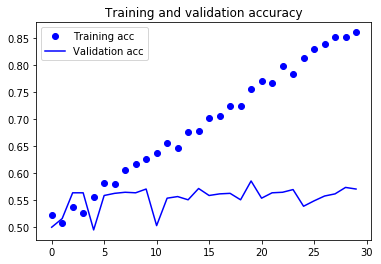

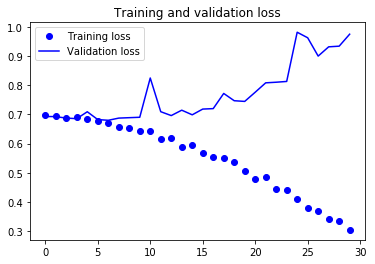

In [55]:
import matplotlib.pyplot as plt

acc = result.history['acc']
val_acc = result.history['val_acc']
loss = result.history['loss']
val_loss = result.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We're overfitting, as we can see the train loss and accuracy move in the directions we want, but the validation loss starts to climb around the 5th epoch and its accuracy never gets above 0.6. Similar to the original exercise. We might want to try the data augmentation steps, but we might also want to look back and see if we're making any bald-faced mistakes in our data processing steps.